<a href="https://colab.research.google.com/github/Valuery/Japanese-License-Plate/blob/main/CNN_Classication_Resnet50V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

XỬ LÝ IMBALANCED DATA

In [ ]:
import Augmentor
from PIL import Image
import random
import numpy as np
from PIL import Image
import cv2

from straug.blur import GaussianBlur, DefocusBlur, MotionBlur, GlassBlur, ZoomBlur
from straug.camera import Contrast, Brightness, JpegCompression, Pixelate
from straug.geometry import Rotate, Perspective, Shrink, TranslateX, TranslateY
from straug.noise import GaussianNoise, ShotNoise, ImpulseNoise, SpeckleNoise
from straug.pattern import VGrid, HGrid, Grid, RectGrid, EllipseGrid
from straug.process import Posterize, Solarize, Invert, Equalize, AutoContrast, Sharpness, Color
from straug.warp import Curve, Distort, Stretch
from straug.weather import Fog, Snow, Frost, Rain, Shadow

In [ ]:
train_aug_path = '/home/anlab/License_plate/Recogniton_License_Area_Finetune_With_Real_Dataset_And_Augment/Undone_image_search/'
train_aug_folder = os.listdir(train_aug_path)

In [ ]:
for folder in train_aug_folder:
    path = train_aug_path + folder + '/'
    p = Augmentor.Pipeline(path)
    p.rotate(probability=0.7, max_left_rotation=5, max_right_rotation=5)
    p.sample(1000)

In [ ]:
for folder in train_aug_folder:
    path = train_aug_path + folder + '/output/'
    image_file = os.listdir(path)
    for image in image_file:
        path_image = path + image
        
        img = Image.open(path_image)
        # img = img.resize((472,236), Image.BICUBIC)
        choice = random.uniform(0,1)
        choice_mag = random.randint(0, 2)

        rotate = True
        angle = 0
        try: 
            if choice > 0.2: 
                img, angle = Rotate()(img, mag=choice_mag)
                # img = ZoomBlur()(img, mag=1)
                rotate = False
            choice = random.uniform(0,1)
            if choice > 0.2: 
                img = MotionBlur()(img, mag=0)
                img = ImpulseNoise()(img, mag=0)
            choice = random.uniform(0,1)
            if choice > 0.2 and rotate == True:
                img = Perspective()(img,0)
            # choice = random.uniform(0,1)
            # choice_mag = random.randint(0,2)
            # if choice > 0.6: img = Snow()(img, mag=0)
            # choice = random.uniform(0,1)
            # choice_mag = random.randint(0,2)
            # if choice > 0.9 : img = Frost(img, mag=0)
            choice = random.uniform(0,1)
            choice_mag = random.randint(0,2)
            # if choice > 0.8 : img = Rain(img, mag = 0)
            if choice > 0.3: img = Contrast()(img, mag=choice_mag)
            choice = random.uniform(0,1)
            choice_mag = random.randint(0,2)
            if choice > 0.8 : img = Brightness(img, mag=choice_mag)
            # choice = random.uniform(0,1)
            # choice_mag = random.randint(0,2)
            # if choice > 0.2 : img = JpegCompression()(img, mag=choice_mag)
            # choice = random.uniform(0,1)
            # choice_mag = random.randint(0,2)
            # if choice > 0.5 : img = Pixelate()(img, mag=choice_mag)
            choice = random.uniform(0,1)
            choice_mag = random.randint(0,2)
            if choice > 0.4 : img = Color()(img, mag=choice_mag)
        except:
            pass
        image = image[0:len(image)-4]
        img = np.array(img)
        if not os.path.isdir(train_aug_path + folder+'/out_put_aug/'): os.makedirs(train_aug_path + folder+'/out_put_aug/')
        cv2.imwrite(train_aug_path + folder+'/out_put_aug/{}.jpg'.format(str(image)), cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

CLASSIFICATION REGION PLATE

In [ ]:
import os
import cv2
import glob

import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import Model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print("FOUND GPU")
else:
    print("GPU NOT FOUND")

FOUND GPU


Check dữ liệu

In [ ]:
class EDA_DATA():
    def __init__(self, data_path):
        self.data_path = data_path
        self.data_frame = self.make_data_frame()
        
        
    def make_data_frame(self):
        path_images = list(glob.glob(self.data_path+"/**/*.jpg"))
        labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], path_images))
        files_path = pd.Series(path_images, name="File_Path").astype('str')
        labels = pd.Series(labels, name='Labels')
        data = pd.concat([files_path, labels], axis=1)
        data = data.sample(frac=1).reset_index(drop=True)
        return data
    
    
    def show_data(self):
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(plt.imread(self.data_frame["File_Path"][i]))
            ax.set_title(self.data_frame["Labels"][i])
            ax.axis('off')
        plt.tight_layout()
        plt.show()
    
    
    def show_sample_classes(self):
        plt.figure(figsize=(20,10))
        labels_counts = self.data_frame["Labels"].value_counts()
        sns.barplot(x=labels_counts.index, y=labels_counts)
        plt.xlabel("Labels")
        plt.ylabel("# Samples")
        plt.xticks(rotation=90)

In [ ]:
DATASET_PATH = 'D:/Squence Diagram/DeepLearning/AI_Insight_CNN_Pytorch/real_dataset/'

In [ ]:
eda_real_dataset = EDA_DATA(DATASET_PATH)

Show sample của dữ liệu, mỗi class gồm 1000 sample đã được xử lý

D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 27700 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 25144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 37326 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 30000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 29066 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 35895 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda\lib\site-package

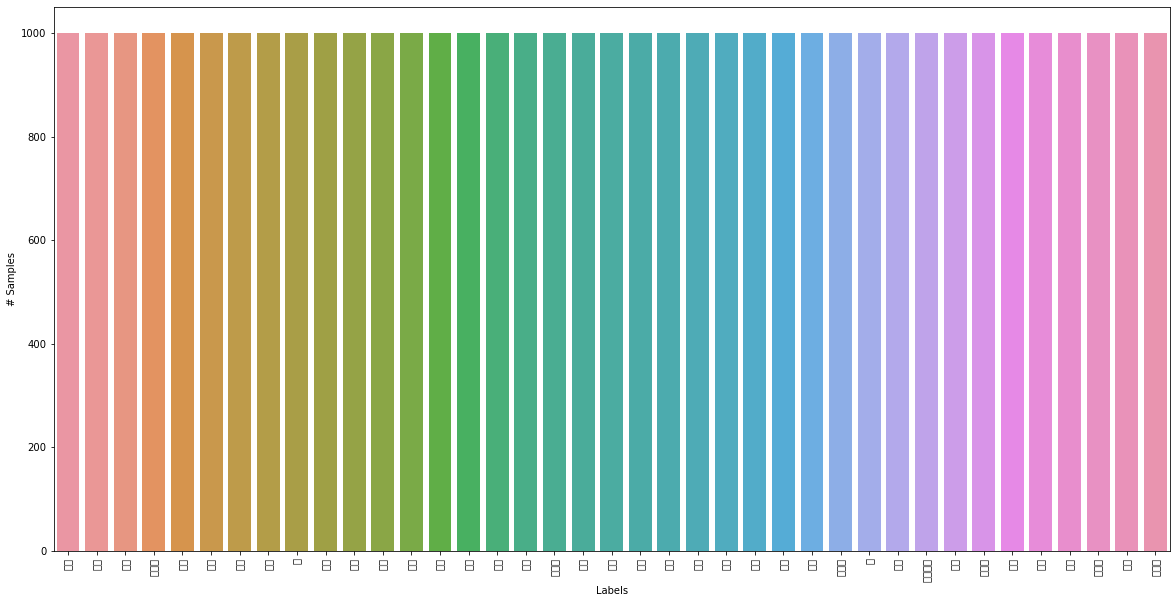

In [ ]:
eda_real_dataset.show_sample_classes()

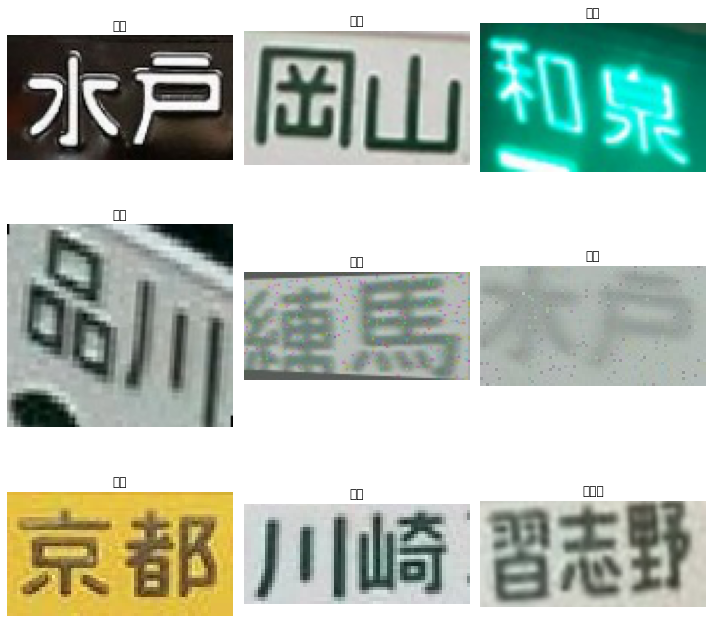

In [ ]:
eda_real_dataset.show_data()

Thực hiện đưa dữ liệu đầu vào về 128x128, batch_size là 64, tỉ lệ chia là 8:2

In [ ]:
batch_size = 64
img_height = 128
img_width = 128

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory=DATASET_PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 41010 files belonging to 40 classes.
Using 32808 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  directory=DATASET_PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = False)

Found 41010 files belonging to 40 classes.
Using 8202 files for validation.


Có tổng cộng 40 class trong tập dữ liệu

In [ ]:
class_names = train_ds.class_names
print(class_names)

['なにわ', '三重', '京', '京都', '八戸', '八王子', '千葉', '名古屋', '和歌山', '和泉', '品川', '多摩', '大宮', '大阪', '奈良', '姫路', '宇都宮', '宮城', '富山', '尾張小牧', '山梨', '岡山', '川崎', '所沢', '春日部', '横浜', '水戸', '沖', '沼津', '滋賀', '熊谷', '相模', '神戸', '練馬', '群馬', '習志野', '足立', '野田', '長野', '静岡']


Augmented tập dữ liệu bằng randomFlip, randomRotation, randomTranslation

In [ ]:
from tensorflow.python.keras.layers.core import Lambda
data_augmentation = tf.keras.Sequential([
      layers.Lambda(lambda x: tf.keras.applications.resnet50.preprocess_input(x)),
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomTranslation(height_factor=(-0.1,0.1), width_factor=(-0.1, 0.1), fill_mode='nearest')
])

Mỗi batch trong train_ds có shape là (64,128,128,3)

In [ ]:
for images, labels in train_ds:
  print(images.shape)
  print(labels.shape)
  break

(64, 128, 128, 3)
(64,)


Một số subset của các batch dữ liệu trong tập train

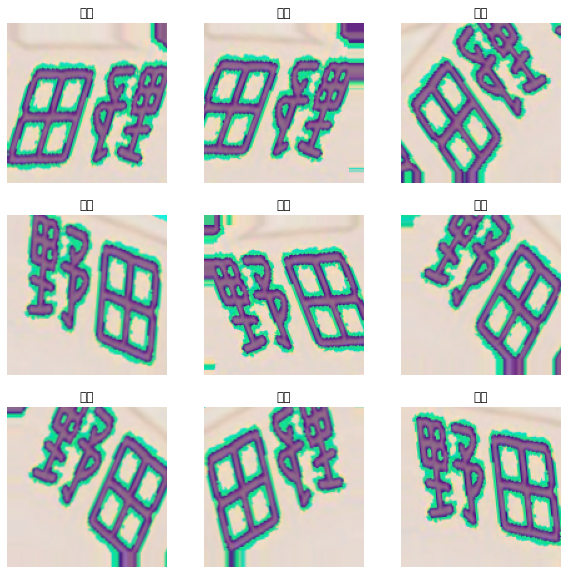

In [ ]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(6):
  for i in range(9):
    ax = plt.subplot(3,3, i+1)
    plt.imshow(data_augmentation(np.expand_dims(images[0].numpy(), axis=0).astype("uint8"))[0])
    plt.title(class_names[labels[0]])
    plt.axis("off")

Xây dựng model, sử dụng model resnet50v2, có weight pretrained model là imagenet

In [ ]:
resnet50_v2_base_model = tf.keras.applications.ResNet50V2(weight='imagenet',include_top=False)

image_input = layers.Input(shape=(img_height, img_width, 3))
x = data_augmentation(image_input)
x = resnet50_v2_base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(units=len(class_names),activation="softmax")(x)

region_plate_classify_resnet50_v2_base_model = Model(inputs=image_input, outputs=x)
region_plate_classify_resnet50_v2_base_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, None, None, 2048)  23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 40)                81960     
                                                                 
Total params: 23,646,760
Trainable params: 23,601,320
Non-trainable params: 45,440
____________________________________________

Optimizer là Adam, loss là CrossEntropy

In [ ]:
region_plate_classify_resnet50_v2_base_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                                                    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                                                    metrics=['accuracy'])
                                                    

Lưu lại checkpoint có giá trị tốt nhất

In [ ]:
from tensorflow.python.eager import monitoring
num_epochs = 50

checkpoint_path='D:/Squence Diagram/DeepLearning/AI_Insight_CNN_Pytorch/resnet50_v2_region_plate.h5'

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only = True,
    monitor='val_accuracy',
    node='max',
    save_best_only=True
)

learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',
                                                               patience = 5, 
                                                               verbose = 1,
                                                               min_lr = 0.00001,
                                                               factor=0.5)

In [ ]:
history = region_plate_classify_resnet50_v2_base_model.fit(train_ds, 
                            epochs = num_epochs,
                            validation_data=val_ds,
                            callbacks=[model_checkpoint])

Epoch 1/10
513/513 [==============================] - ETA: 0s - loss: 0.3687 - accuracy: 0.9156
Epoch 00001: val_accuracy improved from -inf to 0.99598, saving model to D:/Squence Diagram/DeepLearning/AI_Insight_CNN_Pytorch\resnet50_v2_region_plate_version3.h5
513/513 [==============================] - 148s 280ms/step - loss: 0.3687 - accuracy: 0.9156 - val_loss: 0.0166 - val_accuracy: 0.9960
Epoch 2/10
 31/513 [>.............................] - ETA: 2:14 - loss: 0.0285 - accuracy: 0.9909

KeyboardInterrupt: 

Biểu đồ thể hiện giá trị accuracy

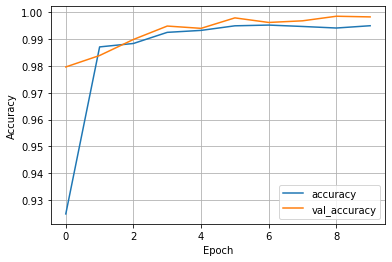

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

Biểu đồ thể hiện giá trị loss

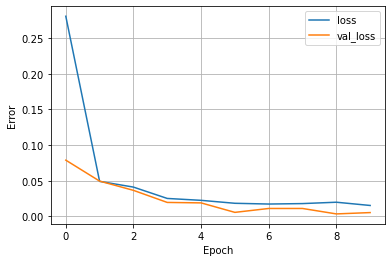

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.grid(True)

Load lại checkpoint, thực hiện kiểm tra

In [ ]:
region_plate_classify_resnet50_v2_base_model.load_weights(checkpoint_path)

In [ ]:
region_plate_classify_resnet50_v2_base_model.evaluate(val_ds)

129/129 [==============================] - 10s 77ms/step - loss: 0.0036 - accuracy: 0.9985


[0.003576492192223668, 0.9985369443893433]

In [ ]:
classes=val_ds.class_names # ordered list of class names
ytrue=[]
for images, label in val_ds:   
    for e in label:
        ytrue.append(classes[e]) # list of class names associated with each image file in test dataset 
ypred=[]
errors=0
count=0
preds=region_plate_classify_resnet50_v2_base_model.predict(val_ds, verbose=1) # predict on the test data
for i, p in enumerate(preds):
    count +=1
    index=np.argmax(p) # get index of prediction with highest probability
    klass=classes[index] 
    ypred.append(klass)
    print(klass+' '+ytrue[i])  
    if klass != ytrue[i]:
        errors +=1
acc= (count-errors)* 100/count
msg=f'there were {count-errors} correct predictions in {count} tests for an accuracy of {acc:6.2f} % '
print(msg) 

129/129 [==============================] - 8s 61ms/step
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模 相模
相模

In [ ]:
def prepare(filepath):
    IMG_SIZE=128
    img_array=cv2.imread(filepath)
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)
    new_array=cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
    return new_array.reshape(-1,IMG_SIZE,IMG_SIZE,3)

In [ ]:
image = prepare(r'D:\Squence Diagram\DeepLearning\AI_Insight_CNN_Pytorch\real_dataset\静岡\静岡_original_静岡.png_0a43748b-4b6a-4672-afeb-3ecf90e0f350.jpg')
ypred = region_plate_classify_resnet50_v2_base_model.predict(image)
y_class = class_names[np.argmax(ypred)]
y_class

'静岡'

In [ ]:
class_names = train_ds.class_names
print(class_names)

['なにわ', '三重', '京', '京都', '八戸', '八王子', '千葉', '名古屋', '和歌山', '和泉', '品川', '多摩', '大宮', '大阪', '奈良', '姫路', '宇都宮', '宮城', '富山', '尾張小牧', '山梨', '岡山', '川崎', '所沢', '春日部', '横浜', '水戸', '沖', '沼津', '滋賀', '熊谷', '相模', '神戸', '練馬', '群馬', '習志野', '足立', '野田', '長野', '静岡']
